# European Call Option Pricing

In this study, we aim to price a European financial contract with a specified payoff structure. The payoff function at maturity \( T \) is given by:

$$
    C(S_T, T) = g(S_T) =
    \begin{cases}
        X_1 - X_2, & \text{if } S_T < X_1, \\
        X_1, & \text{if } X_1 \leq S_T < X_2, \\
        X_2 - X_1, & \text{if } S_T \geq X_2.
    \end{cases}
$$

Given the current asset price \( S_0 \), market prices indicate that the risk-neutral distribution of the asset price at time \( T \) follows:

$$
    S_T \sim \mathcal{N} \left( f(S_0, T), v^2(S_0, T)T \right),
$$

where the functions governing the distribution of the stock price are defined as:

$$
    f(S_0, T) = S_0 \left( e^{\alpha T} - e^{\beta T} \right) + \theta \left(1 + \tanh(\alpha T) - \beta T \right),
$$

$$
    v(S_0, T) = \sigma \sqrt{1 + \alpha T S_0^\gamma}.
$$

These equations describe the expected evolution of the underlying asset price under the risk-neutral measure. The goal of this study is to apply Monte Carlo simulations to approximate the fair value of this financial contract, analyse its convergence, and explore alternative sampling methods for improved efficiency.


In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
# Parameters
S0 = 74827.5
T = 1.75
r = 0.02
alpha = 0.06
beta = 0.04
theta = 74832
sigma = 0.17
gamma = 0.94
X1 = 75000
X2 = 85000
# Payoff function
def g_payoff(S):
    if S < X1:
        return X1 - X2  # -10000
    elif X1 <= S < X2:
        return X1       # 75000
    else:
        return X2 - X1  # 10000
# Distribution    
f_value = S0 * (np.exp(alpha * T) - np.exp(beta * T)) + theta * (1 + np.tanh(alpha * T) - beta * T)
v_value = sigma * np.sqrt(1 + alpha * T) * (S0 ** gamma)
v_sqrtT = v_value * np.sqrt(T)

In [2]:
# Analytic solution 
# Integration
P1 = stats.norm.cdf((75000 - f_value) / v_sqrtT)
P2 = stats.norm.cdf((85000 - f_value) / v_sqrtT) - stats.norm.cdf((75000 - f_value) / v_sqrtT)
P3 = 1 - (P1 + P2)
expected_payoff = (-10000) * P1 + 75000 * P2 + 10000 * P3
C0_exact = np.exp(-r * T) * expected_payoff
print(f"European option price (Numerical quadrature method): {C0_exact:.2f}")

European option price (Numerical quadrature method): 30651.76


In [3]:
# Monte-Carlo Simulation
N = 100000  
phi = np.random.randn(N) # Standard normal samples
S_T = f_value + v_sqrtT * phi
payoffs = np.array([g_payoff(s) for s in S_T])
C0_MC = np.exp(-r * T) * np.mean(payoffs) # Discounted expected payoff
print(f"Monte Carlo Price = {C0_MC:.2f}")

Monte Carlo Price = 30572.81


In [4]:
def mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N=100000):
    # Compute the mean and standard deviation of the normal distribution
    f_value = S0 * (np.exp(alpha * T) - np.exp(beta * T)) \
              + theta * (1 + np.tanh(alpha * T) - beta * T)
    v_value = sigma * np.sqrt(1 + alpha * T) * (S0 ** gamma)
    v_sqrtT = v_value * np.sqrt(T)
    
    # Generate N standard normal samples
    phi = np.random.randn(N)
    # Obtain the corresponding S_T samples
    S_T = f_value + v_sqrtT * phi
    
    # Compute the payoff for each sample
    payoffs = np.array([g_payoff(s) for s in S_T])
    # Take the average of the payoffs and discount it
    return np.exp(-r * T) * np.mean(payoffs)

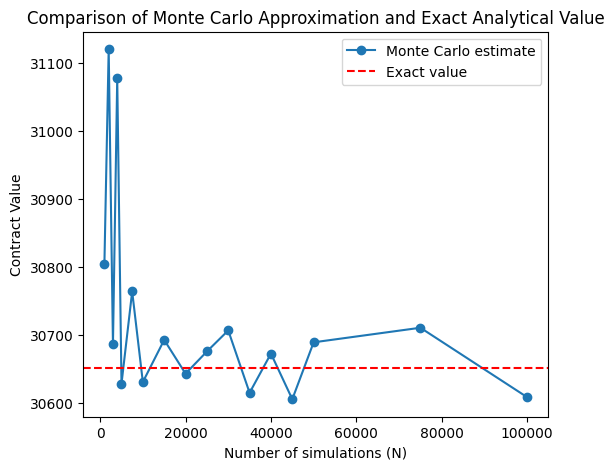

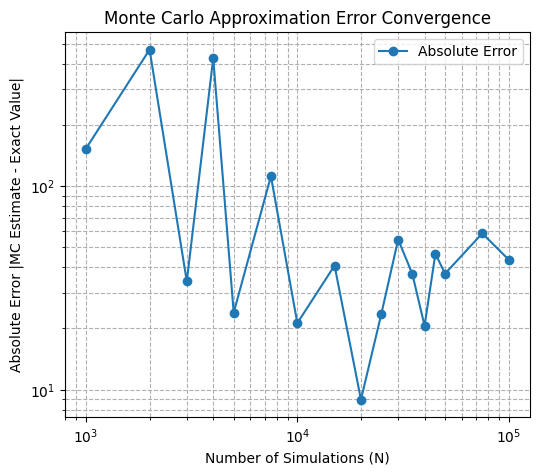

In [5]:
# Simulation
N_values = [1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 75000, 100000]
mc_results = []

for N in N_values:
    price_est = mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N)
    mc_results.append(price_est)

# Monte Carlo Estimation (with multiple runs to smooth results)
mc_results = np.array([np.mean([mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N) 
                                for _ in range(10)]) for N in N_values])

# Compute absolute error
errors = np.abs(np.array(mc_results) - C0_exact)

# Plotting
plt.figure(figsize=(6, 5))
plt.plot(N_values, mc_results, marker='o', label='Monte Carlo estimate')
plt.axhline(C0_exact, color='red', linestyle='--', label='Exact value')
plt.xlabel('Number of simulations (N)')
plt.ylabel('Contract Value')
plt.title('Comparison of Monte Carlo Approximation and Exact Analytical Value')
plt.legend()
plt.show()

# Plot Error vs N
plt.figure(figsize=(6, 5))
plt.loglog(N_values, errors, marker='o', linestyle='-', label='Absolute Error')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Absolute Error |MC Estimate - Exact Value|')
plt.title('Monte Carlo Approximation Error Convergence')
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()


## Variance reduction techniques for European options

This study compares four variance reduction techniques in Monte Carlo option pricing: different random number generators, antithetic variates, moment matching and Halton sequences. The results demonstrate that while standard random number generators provide a baseline for comparison, their effectiveness is limited by inherent stochastic fluctuations. Antithetic variates is ineffective when the payoff function is piecewise constant. Moment matching improves estimation accuracy, particularly for small sample sizes, by enforcing strict mean and variance constraints on the generated normal samples. However, its effect diminishes as the sample size increases due to the natural convergence of sample moments.

Among the methods tested, the Halton sequence outperforms the others by achieving significantly lower error rates across all sample sizes. Unlike antithetic variates and moment matching, which primarily stabilize variance under specific conditions, Halton sequences consistently enhance accuracy by ensuring a more uniform sample distribution. Although the computational cost of generating Halton sequences is higher due to the inverse cumulative distribution function transformation, this additional cost is offset by requiring fewer samples to achieve the same error level. As a result, Halton sequences offer the most efficient balance between accuracy and computational efficiency, making them the superior choice for Monte Carlo-based European biased option pricing.

In [6]:
def mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N=100000, rng=None):
    if rng is None:
        rng = np.random.default_rng() 
    f_value = S0 * (np.exp(alpha * T) - np.exp(beta * T)) + theta * (1 + np.tanh(alpha * T) - beta * T)
    v_value = sigma * np.sqrt(1 + alpha * T) * (S0 ** gamma)
    v_sqrtT = v_value * np.sqrt(T)
    phi = rng.standard_normal(N)
    S_T = f_value + v_sqrtT * phi
    payoffs = np.array([g_payoff(s) for s in S_T])
    return np.exp(-r * T) * np.mean(payoffs)

# Different RNG
rng_list = {
    "Default (PCG64)": np.random.default_rng(),
    "MT19937 (Mersenne Twister)": np.random.RandomState(),
    "PCG64": np.random.Generator(np.random.PCG64()),
    "Philox": np.random.Generator(np.random.Philox(10)),
    "SFC64": np.random.Generator(np.random.SFC64()),
}

N_values = [100000]
results = {}

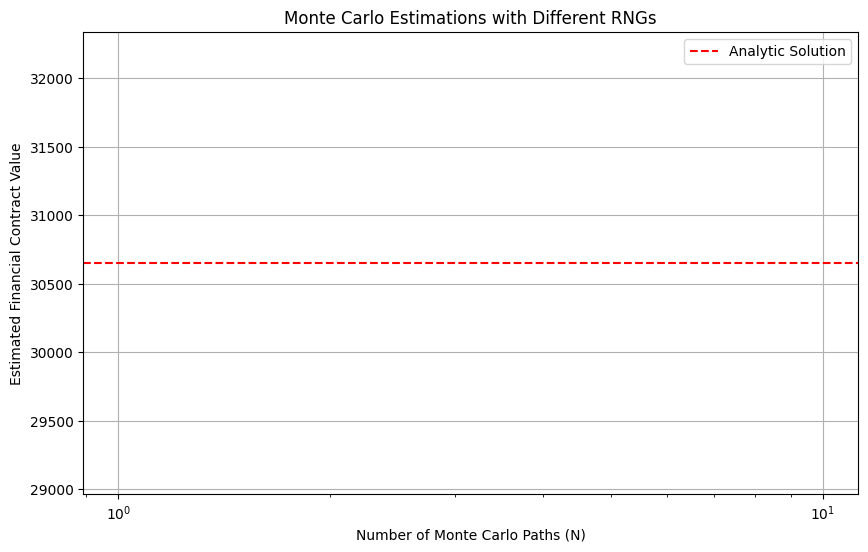

In [7]:
# Plotting
plt.figure(figsize=(10, 6))
for rng_name, data in results.items():
    N_values = [x[0] for x in data]
    prices = [x[1] for x in data]
    plt.plot(N_values, prices, marker='o', label=rng_name)

plt.axhline(C0_exact, color='r', linestyle='--', label="Analytic Solution")
plt.xlabel("Number of Monte Carlo Paths (N)")
plt.ylabel("Estimated Financial Contract Value")
plt.xscale("log")
plt.legend()
plt.title("Monte Carlo Estimations with Different RNGs")
plt.grid()
plt.show()

,Method,N,Estimated Price,Error (%),Time (s)
0,Standard MC,1000,31193.882972,1.768659,0.000499
1,Antithetic MC,1000,29817.895254,2.720440,0.000369
2,Standard MC,2000,30807.640806,0.508561,0.000654
3,Antithetic MC,2000,30298.283949,1.153193,0.000597
4,Standard MC,5000,30873.301974,0.722778,0.001552
5,Antithetic MC,5000,30784.466276,0.432955,0.001498
6,Standard MC,10000,30687.905734,0.117931,0.004149
7,Antithetic MC,10000,29689.469734,3.139423,0.003535
8,Standard MC,50000,30749.897602,0.320176,0.016309
9,Antithetic MC,50000,30528.967083,0.400600,0.014952


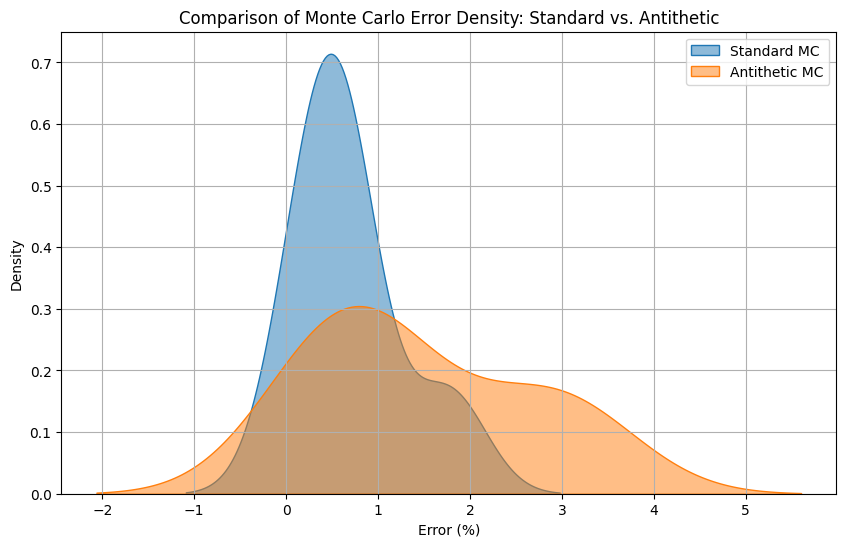

In [8]:
import seaborn as sns
import pandas as pd

# Antithetic Monte Carlo
def mc_price_antithetic(S0, T, r, alpha, beta, theta, sigma, gamma, N=100000, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    N_half = N // 2  
    phi = rng.standard_normal(N_half)
    phi_antithetic = -phi  # Antithetic Variables

    S_T1 = f_value + v_sqrtT * phi
    S_T2 = f_value + v_sqrtT * phi_antithetic

    payoffs1 = np.array([g_payoff(s) for s in S_T1])
    payoffs2 = np.array([g_payoff(s) for s in S_T2])

    payoffs = 0.5 * (payoffs1 + payoffs2)  # 取平均
    return np.exp(-r * T) * np.mean(payoffs)

# Test
N_values = [1000, 2000, 5000, 10000, 50000, 100000]
results = []

for N in N_values:
    rng = np.random.default_rng() #use default rng
    # Standard Monte Carlo
    start = time.time()
    price_mc = mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N, rng)
    time_mc = time.time() - start
    # Antithetic Monte Carlo
    start = time.time()
    price_av = mc_price_antithetic(S0, T, r, alpha, beta, theta, sigma, gamma, N, rng)
    time_av = time.time() - start
    # Error
    error_mc = abs(price_mc - C0_exact) / C0_exact * 100  
    error_av = abs(price_av - C0_exact) / C0_exact * 100 
    results.append(["Standard MC", N, price_mc, error_mc, time_mc])
    results.append(["Antithetic MC", N, price_av, error_av, time_av])

df_results = pd.DataFrame(results, columns=["Method", "N", "Estimated Price", "Error (%)", "Time (s)"])
display(df_results)


plt.figure(figsize=(10, 6))

for method in ["Standard MC", "Antithetic MC"]:
    subset = df_results[df_results["Method"] == method]
    sns.kdeplot(subset["Error (%)"], label=method, fill=True, alpha=0.5)

plt.xlabel("Error (%)")
plt.ylabel("Density")
plt.title("Comparison of Monte Carlo Error Density: Standard vs. Antithetic")
plt.legend()
plt.grid()
plt.show()




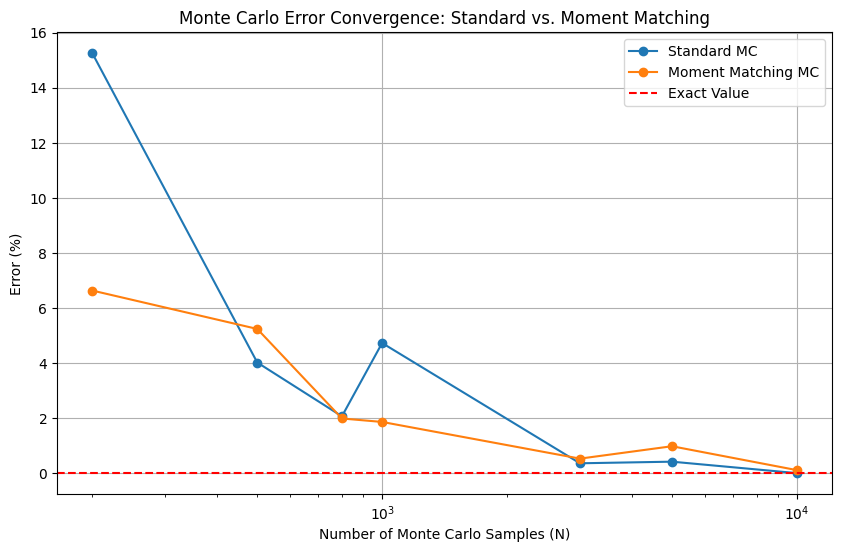

In [9]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# **Standard Monte Carlo Simulation**
def mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N=100000, rng=None):
    """
    Computes the option price using a standard Monte Carlo method.
    
    Parameters:
    - S0: Initial asset price
    - T: Time to maturity
    - r: Risk-free interest rate
    - alpha, beta, theta, sigma, gamma: Model-specific parameters
    - N: Number of Monte Carlo simulations (default: 100000)
    - rng: Random number generator (default: None, initializes a new generator)
    
    Returns:
    - Discounted expected payoff of the option
    """
    if rng is None:
        rng = np.random.default_rng()
    
    phi = rng.standard_normal(N)  # Generate standard normal random numbers
    S_T = f_value + v_sqrtT * phi  # Simulate asset price paths
    
    payoffs = np.array([g_payoff(s) for s in S_T])  # Compute payoff for each path
    return np.exp(-r * T) * np.mean(payoffs)  # Discount the expected payoff


# **Moment Matching Monte Carlo Simulation**
def mc_price_moment_matching(S0, T, r, alpha, beta, theta, sigma, gamma, N=100000, rng=None):
    """
    Computes the option price using Monte Carlo with moment matching.
    
    Parameters:
    - S0: Initial asset price
    - T: Time to maturity
    - r: Risk-free interest rate
    - alpha, beta, theta, sigma, gamma: Model-specific parameters
    - N: Number of Monte Carlo simulations (default: 100000)
    - rng: Random number generator (default: None, initializes a new generator)
    
    Returns:
    - Discounted expected payoff of the option
    """
    if rng is None:
        rng = np.random.default_rng()

    phi = rng.standard_normal(N)  # Generate standard normal random numbers

    # **Apply Moment Matching Technique**
    phi_mean = np.mean(phi)
    phi_std = np.std(phi)
    phi_matched = (phi - phi_mean) / phi_std  # Adjust to have mean=0 and variance=1

    S_T = f_value + v_sqrtT * phi_matched  # Simulate asset price paths

    payoffs = np.array([g_payoff(s) for s in S_T])  # Compute payoff for each path
    return np.exp(-r * T) * np.mean(payoffs)  # Discount the expected payoff


# **Testing Different Monte Carlo Methods**
N_values = [200, 500, 800, 1000, 3000, 5000, 10000]  # Different numbers of samples
results = []

for N in N_values:
    rng = np.random.default_rng()
    
    # Compute price using standard Monte Carlo
    start = time.time()
    price_mc = mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N, rng)
    time_mc = time.time() - start
    
    # Compute price using moment matching Monte Carlo
    start = time.time()
    price_mm = mc_price_moment_matching(S0, T, r, alpha, beta, theta, sigma, gamma, N, rng)
    time_mm = time.time() - start
    
    # Compute percentage error
    error_mc = abs(price_mc - C0_exact) / C0_exact * 100  # Error for standard MC
    error_mm = abs(price_mm - C0_exact) / C0_exact * 100  # Error for moment matching MC
    
    results.append(["Standard MC", N, price_mc, error_mc, time_mc])
    results.append(["Moment Matching MC", N, price_mm, error_mm, time_mm])

# **Convert results into a DataFrame**
df_results = pd.DataFrame(results, columns=["Method", "N", "Estimated Price", "Error (%)", "Time (s)"])

# **Plot Error Comparison Between Methods**
plt.figure(figsize=(10, 6))
for method in ["Standard MC", "Moment Matching MC"]:
    subset = df_results[df_results["Method"] == method]
    plt.plot(subset["N"], subset["Error (%)"], marker='o', label=method)

plt.axhline(0, color='r', linestyle='--', label="Exact Value")  # Horizontal line for exact price
plt.xscale("log")  # Log scale for N
plt.xlabel("Number of Monte Carlo Samples (N)")
plt.ylabel("Error (%)")
plt.legend()
plt.title("Monte Carlo Error Convergence: Standard vs. Moment Matching")
plt.grid()
plt.show()


,Method,N,Estimated Price,Error (%),Time (s)
0,Standard MC,1000,30942.825564,0.949595,0.000621
1,Halton MC,1000,30629.003804,0.074234,0.008383
2,Standard MC,5000,30814.400044,0.530613,0.001840
3,Halton MC,5000,30650.247123,0.004929,0.005257
4,Standard MC,10000,30312.768030,1.105940,0.003148
5,Halton MC,10000,30650.247123,0.004929,0.006869
6,Standard MC,50000,30892.131280,0.784207,0.014192
7,Halton MC,50000,30654.302666,0.008302,0.031749
8,Standard MC,100000,30912.215872,0.849732,0.029814
9,Halton MC,100000,30652.033493,0.000899,0.062726


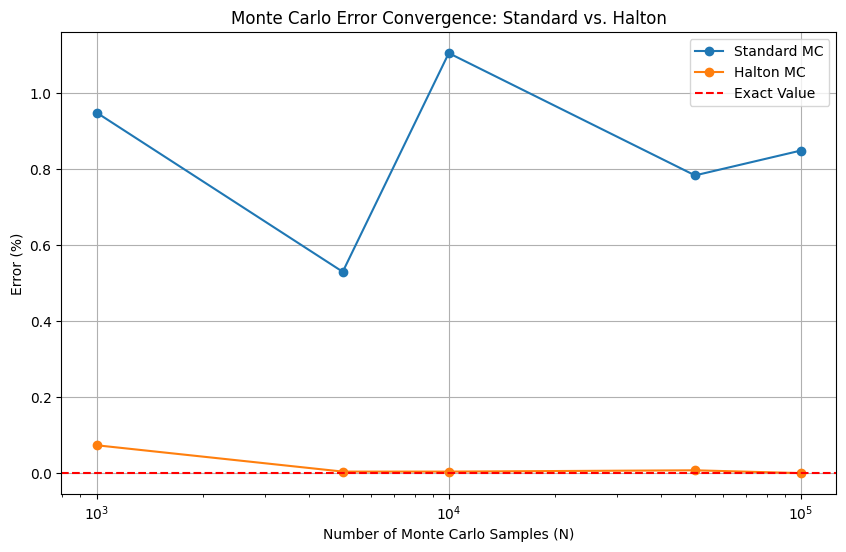

In [10]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats.qmc import Halton  # Import Halton sequence generator

# **Halton Sequence Monte Carlo Simulation**
def mc_price_halton(S0, T, r, alpha, beta, theta, sigma, gamma, N=100000):
    """
    Computes the option price using a Monte Carlo method based on the Halton sequence.
    
    Parameters:
    - S0: Initial asset price
    - T: Time to maturity
    - r: Risk-free interest rate
    - alpha, beta, theta, sigma, gamma: Model-specific parameters
    - N: Number of Monte Carlo simulations (default: 100000)
    
    Returns:
    - Discounted expected payoff of the option
    """
    sampler = Halton(d=1, scramble=True)  # Initialize a Halton low-discrepancy sequence generator
    phi = sampler.random(N).flatten()  # Generate Halton sequence samples
    phi = norm.ppf(phi)  # Transform the samples into a standard normal distribution

    S_T = f_value + v_sqrtT * phi  # Simulate asset price paths

    payoffs = np.array([g_payoff(s) for s in S_T])  # Compute payoffs for each simulated path
    return np.exp(-r * T) * np.mean(payoffs)  # Discount the expected payoff


# **Testing Different Monte Carlo Methods**
N_values = [1000, 5000, 10000, 50000, 100000]  # Different sample sizes for Monte Carlo estimation
results = []

for N in N_values:
    rng = np.random.default_rng()
    
    # Compute price using standard Monte Carlo
    start = time.time()
    price_mc = mc_price(S0, T, r, alpha, beta, theta, sigma, gamma, N, rng)
    time_mc = time.time() - start
    
    # Compute price using Halton-based Monte Carlo
    start = time.time()
    price_halton = mc_price_halton(S0, T, r, alpha, beta, theta, sigma, gamma, N)
    time_halton = time.time() - start
    
    # Compute percentage error
    error_mc = abs(price_mc - C0_exact) / C0_exact * 100  # Error for standard MC
    error_halton = abs(price_halton - C0_exact) / C0_exact * 100  # Error for Halton MC
    
    results.append(["Standard MC", N, price_mc, error_mc, time_mc])
    results.append(["Halton MC", N, price_halton, error_halton, time_halton])

# **Convert results into a DataFrame**
df_results = pd.DataFrame(results, columns=["Method", "N", "Estimated Price", "Error (%)", "Time (s)"])
display(df_results)

# **Plot Error Comparison Between Methods**
plt.figure(figsize=(10, 6))
for method in ["Standard MC", "Halton MC"]:
    subset = df_results[df_results["Method"] == method]
    plt.plot(subset["N"], subset["Error (%)"], marker='o', label=method)

plt.axhline(0, color='r', linestyle='--', label="Exact Value")  # Reference line for exact price
plt.xscale("log")  # Use logarithmic scale for sample size (N)
plt.xlabel("Number of Monte Carlo Samples (N)")
plt.ylabel("Error (%)")
plt.title("Monte Carlo Error Convergence: Standard vs. Halton")
plt.legend()
plt.grid()
plt.show()


# Up-and-Out Barrier Call Option

We price a discrete up-and-out barrier call option \(V\), assuming the underlying asset follows the risk-neutral process:

$$
    dS = (\alpha\theta - \beta S)dt + \sigma(|S|)^\gamma dW,
$$

where \( S \) is the asset price, \( W \) is a standard Wiener process, and \( \alpha, \beta, \gamma, \theta, \sigma \) are constant parameters.

The asset price is observed at \( K+1 \) equally spaced times:

$$
t_0, t_1, ..., t_k = k\Delta t, ..., t_K, \quad t_0 = 0, \quad t_K = T, \quad \Delta t = \frac{T}{K}.
$$

Using an Euler discretization scheme, the asset price evolves as:

$$
    S^i(t_k) = S^i(t_{k-1}) + f(S^i(t_{k-1}), t_{k-1})\Delta t + v(S^i(t_{k-1}), t_{k-1})\sqrt{\Delta t} \, \phi_{i,k-1},
$$

where \( \phi_{i,k} \sim N(0,1) \) is a standard normal variable.

The option payoff depends on the full price path $\{S(t_0), ..., S(t_K)\}$, and its value is approximated via Monte Carlo:

$$
    V(S(t_0), t = 0) \approx e^{-rT} \frac{1}{n} \sum_{i=1}^{n} g(S^i(t_0), ..., S^i(t_K)).
$$


In [11]:
import numpy as np

# -----------------------------
# 1. Given Parameters
# -----------------------------
S0 = 65.15665   # Initial stock price
X  = 65         # Strike price
B  = 77.9       # Upper barrier level
T  = 0.5        # Time to maturity (in years)
K  = 65         # Number of discrete sampling steps
r  = 0.03       # Risk-free interest rate
alpha = 0.02
beta  = 0.03
gamma = 1.07
sigma = 0.36
theta = 65.1404
N = 100000      # Number of Monte Carlo simulation paths

# Time step length
dt = T / K

# -----------------------------
# 2. Monte Carlo Simulation
# -----------------------------
np.random.seed(42)  # Set random seed for reproducibility
payoffs = np.zeros(N)  # Initialize array to store payoffs

for i in range(N):
    S_t = S0  # Initialize stock price at time t=0
    barrier_hit = False  # Flag to track whether the barrier is breached
    
    # Generate K standard normal random variables for this path
    Z = np.random.randn(K)  
    
    for k in range(K):
        # Compute Wiener process increment: dW = sqrt(dt) * Z[k]
        dW = np.sqrt(dt) * Z[k]
        
        # Euler-Maruyama discretization:
        # dS = (alpha*theta - beta*S_t)*dt + sigma*(|S_t|^gamma)*dW
        drift = (alpha * theta - beta * S_t) * dt
        diffusion = sigma * (abs(S_t)**gamma) * dW
        
        S_t = S_t + drift + diffusion  # Update stock price
        
        # Check if the barrier has been breached
        if S_t > B:
            barrier_hit = True
            break  # Exit the loop early if the barrier is hit
    
    # If the option has not been knocked out, compute the final payoff
    if not barrier_hit:
        payoffs[i] = max(S_t - X, 0)  # European call option payoff

# -----------------------------
# 3. Compute Option Price (Discounted Mean)
# -----------------------------
option_price = np.exp(-r * T) * np.mean(payoffs)
print("Up-and-Out Barrier Call Option Price =", option_price)



Up-and-Out Barrier Call Option Price = 0.2901948436956547


Number of paths: 1000, Option Price: 0.2647
Number of paths: 5000, Option Price: 0.2513
Number of paths: 10000, Option Price: 0.2666
Number of paths: 50000, Option Price: 0.2918
Number of paths: 100000, Option Price: 0.2902
Number of paths: 1000000, Option Price: 0.2850


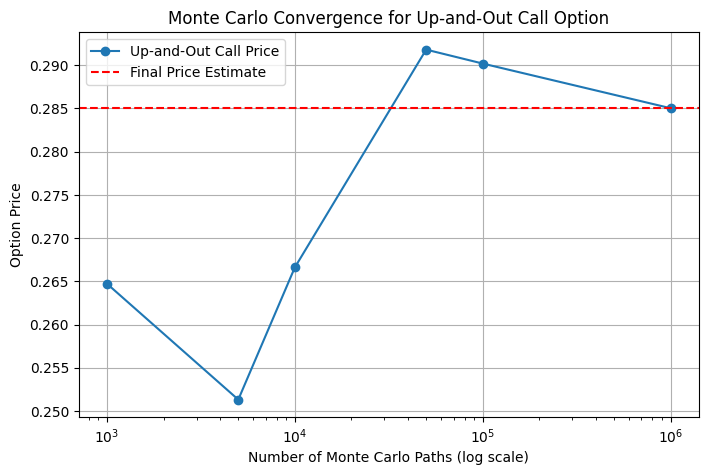

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------
# 1. Given Parameters
# -----------------------------
S0 = 65.15665   # Initial stock price
X  = 65         # Strike price
B  = 77.9       # Barrier level (knock-out threshold)
T  = 0.5        # Time to maturity (years)
K  = 65         # Number of discrete time steps
r  = 0.03       # Risk-free interest rate
alpha = 0.02
beta  = 0.03
gamma = 1.07
sigma = 0.36
theta = 65.1404
N = 100000      # Number of simulation paths

dt = T / K      # Time step size

# -----------------------------
# 2. Monte Carlo Simulation Function (Refined Version)
# -----------------------------
def monte_carlo_up_and_out(n_paths):
    """
    Computes the price of an up-and-out call option using Monte Carlo simulation.
    
    Parameters:
    - n_paths: Number of Monte Carlo simulation paths
    
    Returns:
    - Estimated option price
    """
    
    payoffs = np.zeros(n_paths)  # Initialize array for payoffs
    
    np.random.seed(42)  # Set a fixed random seed for reproducibility

    for i in range(n_paths):
        S_t = np.full(K + 1, S0)  # Store the full stock price path
        Z = np.random.randn(K)  # Generate standard normal random variables
        
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]  # Wiener process increment
            drift = (alpha * theta - beta * S_t[k]) * dt  # Drift term
            diffusion = sigma * (abs(S_t[k]) ** gamma) * dW  # Diffusion term
            S_t[k + 1] = S_t[k] + drift + diffusion  # Update stock price path
        
        # **Correct Knock-out Condition**: Check if the maximum price exceeds the barrier
        if np.max(S_t) > B:
            payoffs[i] = 0  # Knocked out, option is worthless
        else:
            payoffs[i] = max(S_t[-1] - X, 0)  # Compute payoff for a European call option
    
    # Compute the discounted expected payoff to estimate the option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# -----------------------------
# 3. Testing Convergence with Different Numbers of Paths
# -----------------------------
n_values = [1000, 5000, 10000, 50000, 100000, 1000000]
option_prices = []

for n in n_values:
    price = monte_carlo_up_and_out(n)
    option_prices.append(price)
    print(f"Number of paths: {n}, Option Price: {price:.4f}")

# -----------------------------
# 4. Plot Convergence Curve
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(n_values, option_prices, marker='o', linestyle='-', label="Up-and-Out Call Price")
plt.axhline(y=option_prices[-1], color='r', linestyle='--', label="Final Price Estimate")  # Reference line for convergence
plt.xscale('log')  # Logarithmic scale for sample size
plt.xlabel("Number of Monte Carlo Paths (log scale)")
plt.ylabel("Option Price")
plt.title("Monte Carlo Convergence for Up-and-Out Call Option")
plt.legend()
plt.grid(True)
plt.show()



## Sensitivity Analysis

In this study, we implemented a Monte Carlo-based approach to price a discrete up-and-out barrier call option and analyzed the sensitivity of the option value with respect to the model parameter $\beta$. Through sensitivity analysis, we found that the Monte Carlo estimate of $V(S_0, t=0; \beta=0.03)$ stabilizes for $N > 200,000$, while an optimal choice of $\Delta\beta \approx 0.001$ provides a balance between numerical stability and discretization error.

Furthermore, we compared different Monte Carlo simulation techniques, including QMC, Importance Sampling, Antithetic Variates, and Control Variates. The Antithetic Variates method exhibited the most stable results with a relatively narrow confidence interval, making it the most effective technique for this path-dependent derivative. While QMC achieved the lowest variance, it also introduced systematic bias, highlighting the trade-offs between variance reduction and unbiasedness. Overall, our findings underscore the importance of selecting appropriate variance reduction methods when estimating sensitivities in highly path-dependent options.

V(β=0.03) = 0.2902
V(β=0.03 + 0.001) = 0.2900
∂V/∂β ≈ -0.235543


,dBeta,N,dV_dBeta
0,0.0100,50000,-0.164286
1,0.0100,100000,-0.286574
2,0.0100,200000,-0.205601
3,0.0050,50000,0.149895
4,0.0050,100000,-0.112798
5,0.0050,200000,-0.177984
6,0.0010,50000,0.447477
7,0.0010,100000,-0.238442
8,0.0010,200000,-0.096074
9,0.0005,50000,0.131469


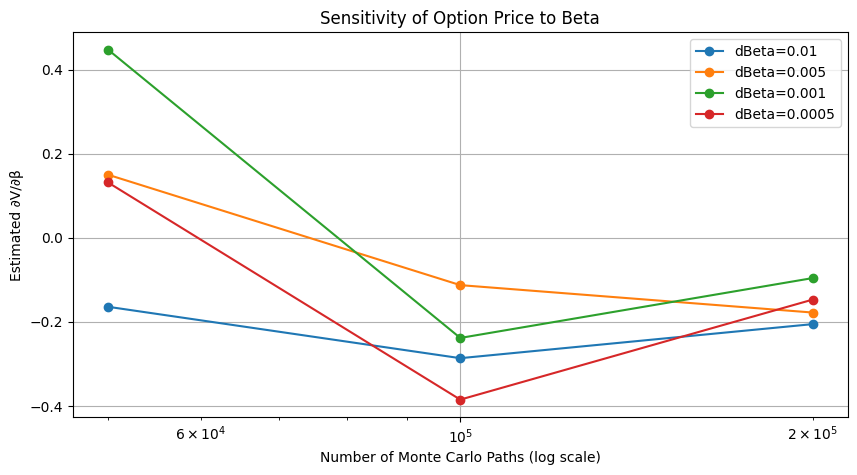

In [14]:
# Sensitivity Analysis with N and Delta Beta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Given Parameters (Fixed except for beta)
# -----------------------------
S0 = 65.15665  # Initial stock price
X = 65         # Strike price
B = 77.9       # Barrier level
T = 0.5        # Time to maturity
K = 65         # Number of time steps
r = 0.03       # Risk-free interest rate
alpha = 0.02
gamma = 1.07
sigma = 0.36
theta = 65.1404

dt = T / K  # Time step size

# -----------------------------
# 2. Monte Carlo Pricing Function
# -----------------------------
def price_option(beta_value, N, seed=42):
    """
    Monte Carlo pricing of an up-and-out barrier call option
    for a given beta (beta_value) and number of simulation paths (N).
    """
    np.random.seed(seed)
    payoffs = np.zeros(N)
    
    for i in range(N):
        S_t = S0
        barrier_hit = False
        
        Z = np.random.randn(K)  # Generate K standard normal variables per path
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S_t) * dt  # Drift term
            diffusion = sigma * (abs(S_t) ** gamma) * dW  # Diffusion term
            S_t += drift + diffusion  # Update stock price
            
            # Check if the barrier is breached
            if S_t > B:
                barrier_hit = True
                break
        
        if not barrier_hit:
            payoffs[i] = max(S_t - X, 0)  # Compute European call option payoff
    
    return np.exp(-r * T) * np.mean(payoffs)

# -----------------------------
# 3. Compute Sensitivity ∂V/∂β for a Single dBeta
# -----------------------------
N_sim = 100000  # Number of Monte Carlo paths
dBeta = 0.001   # Increment for finite difference approximation

V_beta = price_option(0.03, N_sim, seed=42)
V_beta_plus = price_option(0.03 + dBeta, N_sim, seed=42)  

# Compute finite difference estimate of sensitivity
dV_dBeta = (V_beta_plus - V_beta) / dBeta

# Display results
print(f"V(β=0.03) = {V_beta:.4f}")
print(f"V(β=0.03 + {dBeta}) = {V_beta_plus:.4f}")
print(f"∂V/∂β ≈ {dV_dBeta:.6f}")

# -----------------------------
# 4. Compute Sensitivity Across Multiple dBeta and N values
# -----------------------------
betas_delta_list = [0.01, 0.005, 0.001, 0.0005]
N_list = [50000, 100000, 200000]
results = []

for dB in betas_delta_list:
    for N_sim in N_list:
        V1 = price_option(0.03, N_sim)
        V2 = price_option(0.03 + dB, N_sim + 1)  # Change N slightly to avoid exact same paths
        diff = (V2 - V1) / dB
        results.append((dB, N_sim, diff))

# Convert results into a DataFrame for display
df_results = pd.DataFrame(results, columns=["dBeta", "N", "dV_dBeta"])
display(df_results)

# -----------------------------
# 5. Visualization of Sensitivity Results
# -----------------------------
plt.figure(figsize=(10, 5))

# Plot dV/dBeta vs. N for different dBeta values
for dB in betas_delta_list:
    subset = df_results[df_results["dBeta"] == dB]
    plt.plot(subset["N"], subset["dV_dBeta"], marker='o', linestyle='-', label=f"dBeta={dB}")

plt.xscale('log')  # Logarithmic scale for sample size
plt.xlabel("Number of Monte Carlo Paths (log scale)")
plt.ylabel("Estimated ∂V/∂β")
plt.title("Sensitivity of Option Price to Beta")
plt.legend()
plt.grid(True)
plt.show()

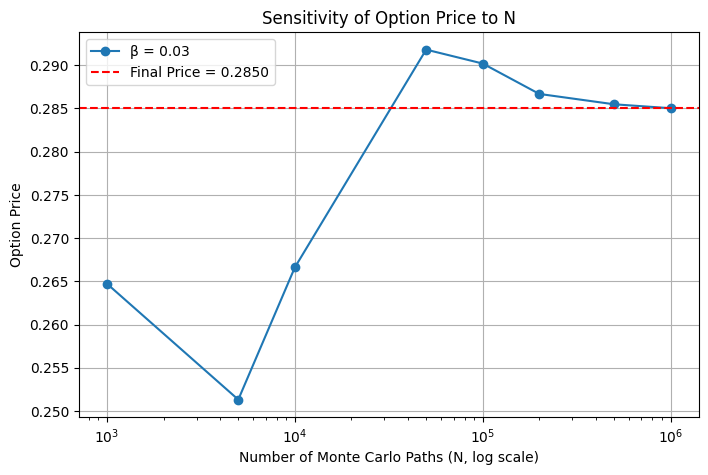

,N,"V(S0, t=0; β=0.03)",Error
0,1000,0.264723,0.020277
1,5000,0.251314,0.033686
2,10000,0.266608,0.018392
3,50000,0.291806,0.006806
4,100000,0.290195,0.005195
5,200000,0.286680,0.001680
6,500000,0.285483,0.000483
7,1000000,0.285029,0.000029


In [ ]:
# Sensitivity Analysis for N
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Given Parameters
# -----------------------------
S0 = 65.15665   # Initial stock price
X  = 65         # Strike price
B  = 77.9       # Upper barrier
T  = 0.5        # Maturity
K  = 65         # Number of time steps
r  = 0.03       # Risk-free rate
alpha = 0.02
beta_base = 0.03  # Base beta value
gamma = 1.07
sigma = 0.36
theta = 65.1404

dt = T / K     # Time step
final_price = 0.2850  # Given final price for error calculation

# -----------------------------
# 2. Monte Carlo Calculation Function
# -----------------------------
def monte_carlo_up_and_out(n_paths, beta_value):
    """
    Monte Carlo simulation to compute the up-and-out call option price.
    """
    payoffs = np.zeros(n_paths)
    np.random.seed(42)  # Fixed seed for reproducibility
    
    for i in range(n_paths):
        S_t = np.full(K + 1, S0)
        Z = np.random.randn(K)  # Generate standard normal variables
        
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S_t[k]) * dt
            diffusion = sigma * (abs(S_t[k]) ** gamma) * dW
            S_t[k + 1] = S_t[k] + drift + diffusion

        # Check for barrier crossing
        if np.max(S_t) > B:
            payoffs[i] = 0  # Knocked out, no value
        else:
            payoffs[i] = max(S_t[-1] - X, 0)

    # Discounting the payoff
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# -----------------------------
# 3. Sensitivity Analysis for N
# -----------------------------
N_values = [1000, 5000, 10000, 50000, 100000, 200000, 500000, 1000000]
option_prices_baseline = []
errors = []

for n in N_values:
    price = monte_carlo_up_and_out(n, beta_base)
    option_prices_baseline.append(price)
    errors.append(abs(price - final_price))  # Compute absolute error

# -----------------------------
# 4. Plot Convergence Curve
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(N_values, option_prices_baseline, marker='o', linestyle='-', label=f"β = {beta_base}")
plt.axhline(y=final_price, color='r', linestyle='--', label=f"Final Price = {final_price:.4f}")
plt.xscale('log')
plt.xlabel("Number of Monte Carlo Paths (N, log scale)")
plt.ylabel("Option Price")
plt.title("Sensitivity of Option Price to N")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5. Save Results to DataFrame and Display
# -----------------------------
df_results = pd.DataFrame({
    "N": N_values,
    "V(S0, t=0; β=0.03)": option_prices_baseline,
    "Error": errors
})

display(df_results)

V(S0, β=0.03) = 0.29019
Δβ = 0.0001, V(S0, β=0.03+Δβ) = 0.29022, dV/dβ ≈ 0.27774
Δβ = 0.0005, V(S0, β=0.03+Δβ) = 0.29001, dV/dβ ≈ -0.37937
Δβ = 0.0010, V(S0, β=0.03+Δβ) = 0.28996, dV/dβ ≈ -0.23554
Δβ = 0.0050, V(S0, β=0.03+Δβ) = 0.28963, dV/dβ ≈ -0.11222
Δβ = 0.0075, V(S0, β=0.03+Δβ) = 0.28864, dV/dβ ≈ -0.20768
Δβ = 0.0090, V(S0, β=0.03+Δβ) = 0.28811, dV/dβ ≈ -0.23215
Δβ = 0.0100, V(S0, β=0.03+Δβ) = 0.28733, dV/dβ ≈ -0.28629
Δβ = 0.0125, V(S0, β=0.03+Δβ) = 0.28622, dV/dβ ≈ -0.31794
Δβ = 0.0150, V(S0, β=0.03+Δβ) = 0.28547, dV/dβ ≈ -0.31485
Δβ = 0.0175, V(S0, β=0.03+Δβ) = 0.28446, dV/dβ ≈ -0.32778
Δβ = 0.0200, V(S0, β=0.03+Δβ) = 0.28305, dV/dβ ≈ -0.35705


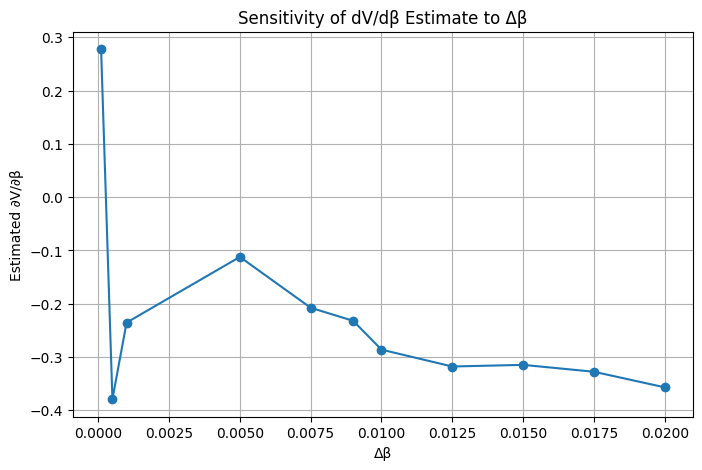

        Δβ  Estimated ∂V/∂β
0   0.0001         0.277745
1   0.0005        -0.379367
2   0.0010        -0.235543
3   0.0050        -0.112218
4   0.0075        -0.207678
5   0.0090        -0.232147
6   0.0100        -0.286287
7   0.0125        -0.317937
8   0.0150        -0.314855
9   0.0175        -0.327780
10  0.0200        -0.357055


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Given Parameters
# -----------------------------
S0 = 65.15665   # Initial stock price
X  = 65         # Strike price
B  = 77.9       # Upper barrier
T  = 0.5        # Time to maturity
K  = 65         # Number of time steps
r  = 0.03       # Risk-free interest rate
alpha = 0.02
beta_base = 0.03  # Base β value
gamma = 1.07
sigma = 0.36
theta = 65.1404
N = 100000     # Number of simulated paths

dt = T / K     # Time step size

# -----------------------------
# 2. Monte Carlo Calculation Function
# -----------------------------
def monte_carlo_up_and_out(n_paths, beta_value):
    """
    Compute the price of an up-and-out call option using the Monte Carlo method.
    The parameter beta_value sets the specific value of β.
    """
    payoffs = np.zeros(n_paths)
    np.random.seed(42)  # Fix random seed for reproducibility
    
    for i in range(n_paths):
        # Initialize path array (length K+1, all starting at S0)
        S_t = np.full(K + 1, S0)
        # Generate K standard normal random variables
        Z = np.random.randn(K)
        
        # Update price at each time step
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S_t[k]) * dt
            diffusion = sigma * (abs(S_t[k]) ** gamma) * dW
            S_t[k + 1] = S_t[k] + drift + diffusion
        
        # Check if the path crosses the barrier B (knock-out condition)
        if np.max(S_t) > B:
            payoffs[i] = 0
        else:
            payoffs[i] = max(S_t[-1] - X, 0)
    
    # Discount payoff to present value to get the option price
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# -----------------------------
# 3. Sensitivity Test for Δβ
# -----------------------------
# Compute base option price V(S0, β=0.03)
V_beta = monte_carlo_up_and_out(N, beta_base)
print(f"V(S0, β={beta_base}) = {V_beta:.5f}")

# Define a series of Δβ values (from small to large)
delta_beta_values = [0.0001, 0.0005, 0.001, 0.005, 0.0075, 0.009, 0.01, 0.0125, 0.015, 0.0175, 0.02]
derivative_estimates = []

for delta in delta_beta_values:
    V_beta_delta = monte_carlo_up_and_out(N, beta_base + delta)
    dV_dBeta = (V_beta_delta - V_beta) / delta
    derivative_estimates.append(dV_dBeta)
    print(f"Δβ = {delta:.4f}, V(S0, β={beta_base}+Δβ) = {V_beta_delta:.5f}, dV/dβ ≈ {dV_dBeta:.5f}")

# -----------------------------
# 4. Plot Sensitivity of dV/dβ Estimate to Δβ
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(delta_beta_values, derivative_estimates, marker='o', linestyle='-')
plt.xlabel("Δβ")
plt.ylabel("Estimated ∂V/∂β")
plt.title("Sensitivity of dV/dβ Estimate to Δβ")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Save Results in DataFrame and Print
# -----------------------------
df_results = pd.DataFrame({
    "Δβ": delta_beta_values,
    "Estimated ∂V/∂β": derivative_estimates
})
print(df_results)

In [ ]:
# Quasi-Monte Carlo (QMC, Halton)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, qmc

# -----------------------------
# 1. Given Parameters
# -----------------------------
S0 = 65.15665   # Initial stock price
X  = 65         # Strike price
B  = 77.9       # Upper barrier
T  = 0.5        # Time to maturity
K  = 65         # Number of time steps
r  = 0.03       # Risk-free interest rate
alpha = 0.02
beta_base = 0.03
gamma = 1.07
sigma = 0.36
theta = 65.1404
dt = T / K

# Parameters to compare
N = 10000        # Number of sample paths per experiment
delta_beta = 0.001
M = 10           # Number of repeated experiments for variance and confidence interval estimation

# -----------------------------
# 2. Standard Monte Carlo (MC) Function
# -----------------------------
def mc_up_and_out(n_paths, beta_value, seed=42):
    """
    Standard Monte Carlo: Simulate the price of an up-and-out call option using standard normal random numbers.
    """
    np.random.seed(seed)
    payoffs = np.zeros(n_paths)
    
    for i in range(n_paths):
        S_t = S0
        barrier_hit = False
        
        # Generate K standard normal random numbers
        Z = np.random.randn(K)
        
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S_t) * dt
            diffusion = sigma * (abs(S_t)**gamma) * dW
            S_t += drift + diffusion
            
            if S_t > B:
                barrier_hit = True
                break
        
        if barrier_hit:
            payoffs[i] = 0.0
        else:
            payoffs[i] = max(S_t - X, 0)
    
    return np.exp(-r*T) * np.mean(payoffs)

# -----------------------------
# 3. Quasi-Monte Carlo (QMC, Halton) Function
# -----------------------------
def qmc_up_and_out(n_paths, beta_value, seed=42):
    """
    Quasi-Monte Carlo based on Halton sequences: Simulate the price of an up-and-out call option using a Halton low-discrepancy sequence.
    """
    # Generate an n_paths * K-dimensional Halton sequence
    # scramble=True randomizes the sequence to reduce systematic bias
    sampler = qmc.Halton(d=K, scramble=True, seed=seed)
    # Generate n_paths K-dimensional vectors (each path has K random numbers)
    # Halton sequences are in [0,1], so they need to be transformed into standard normal using the inverse normal CDF
    U = sampler.random(n_paths)
    Z_mat = norm.ppf(U)  # shape=(n_paths, K)
    
    payoffs = np.zeros(n_paths)
    
    for i in range(n_paths):
        S_t = S0
        barrier_hit = False
        
        # Extract K normal random numbers for this path
        Z = Z_mat[i, :]
        
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S_t) * dt
            diffusion = sigma * (abs(S_t)**gamma) * dW
            S_t += drift + diffusion
            
            if S_t > B:
                barrier_hit = True
                break
        
        if barrier_hit:
            payoffs[i] = 0.0
        else:
            payoffs[i] = max(S_t - X, 0)
    
    return np.exp(-r*T) * np.mean(payoffs)

# -----------------------------
# 4. Repeated Experiments to Compare Variance of dV/dBeta
# -----------------------------
def estimate_derivative_mc(n_paths, delta_beta, method="MC", M=10):
    """
    Repeat M times, estimating dV/dBeta using finite differences in each trial.
    method="MC" or "QMC"
    Returns an array containing M estimates.
    """
    estimates = []
    for i in range(M):
        if method == "MC":
            V1 = mc_up_and_out(n_paths, beta_base, seed=(42+i))  # Vary the seed
            V2 = mc_up_and_out(n_paths, beta_base+delta_beta, seed=(123+i))
        else:  # QMC
            V1 = qmc_up_and_out(n_paths, beta_base, seed=(42+i))
            V2 = qmc_up_and_out(n_paths, beta_base+delta_beta, seed=(123+i))
        
        dV = (V2 - V1) / delta_beta
        estimates.append(dV)
    return np.array(estimates)

# -----------------------------
# 5. Main Process: Compare MC vs. QMC Derivative Estimations
# -----------------------------
mc_estimates = estimate_derivative_mc(N, delta_beta, method="MC", M=M)
qmc_estimates = estimate_derivative_mc(N, delta_beta, method="QMC", M=M)

# Compute Mean and Confidence Interval (Assuming ~ Normal Distribution)
def mean_confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)
    n = len(data)
    # Can use either t-distribution or normal approximation; for sample size >= 30, z=1.96 is a reasonable approximation
    z = 1.96  
    half_width = z * (std_val / np.sqrt(n))
    return mean_val, mean_val - half_width, mean_val + half_width

mc_mean, mc_low, mc_high = mean_confidence_interval(mc_estimates)
qmc_mean, qmc_low, qmc_high = mean_confidence_interval(qmc_estimates)

# -----------------------------
# 6. Print Comparison Results
# -----------------------------
print("=== Comparison of MC vs QMC for dV/dBeta ===")
print(f"MC:  mean={mc_mean:.4f}, 95% CI=({mc_low:.4f}, {mc_high:.4f})")
print(f"QMC: mean={qmc_mean:.4f}, 95% CI=({qmc_low:.4f}, {qmc_high:.4f})")

# Store results in a DataFrame for comparison
df = pd.DataFrame({
    "Method": ["MC", "QMC"],
    "Mean(dV/dBeta)": [mc_mean, qmc_mean],
    "CI Lower": [mc_low, qmc_low],
    "CI Upper": [mc_high, qmc_high]
})
print(df)



=== Comparison of MC vs QMC for dV/dBeta ===
MC:  mean=8.2525, 95% CI=(-4.8133, 21.3184)
QMC: mean=10.9631, 95% CI=(2.6146, 19.3117)
  Method  Mean(dV/dBeta)  CI Lower   CI Upper
0     MC        8.252545 -4.813316  21.318406
1    QMC       10.963110  2.614557  19.311663


In [16]:
# Importance Sampling (IS) Simulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------
# 1. Parameter Settings
# -----------------------------
S0 = 65.15665    # Initial stock price
X  = 65          # Strike price
B  = 77.9        # Upper barrier
T  = 0.5         # Time to maturity
K  = 65          # Number of time steps
r  = 0.03        # Risk-free interest rate
alpha = 0.02
beta_base = 0.03 # Base β value
gamma = 1.07
sigma = 0.36
theta = 65.1404
dt = T / K      # Time step size

# Simulation parameters
N = 10000       # Number of paths per experiment
delta_beta = 0.001  # Perturbation of β
M = 10          # Number of repeated experiments

# -----------------------------
# 2. Standard Monte Carlo Simulation Function
# -----------------------------
def mc_up_and_out(n_paths, beta_value, seed=42):
    """
    Standard Monte Carlo simulation for up-and-out call option pricing.
    No variance reduction techniques are used.
    """
    np.random.seed(seed)
    payoffs = np.zeros(n_paths)
    
    for i in range(n_paths):
        S_t = S0
        barrier_hit = False
        
        Z = np.random.randn(K)
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S_t) * dt
            diffusion = sigma * (abs(S_t)**gamma) * dW
            S_t = S_t + drift + diffusion
            
            if S_t > B:
                barrier_hit = True
                break
        if barrier_hit:
            payoffs[i] = 0.0
        else:
            payoffs[i] = max(S_t - X, 0)
            
    option_price = np.exp(-r*T) * np.mean(payoffs)
    return option_price

# -----------------------------
# 3. Importance Sampling (IS) Simulation Function
# -----------------------------
def is_mc_up_and_out(n_paths, beta_value, seed=42, drift_adjust=0.1):
    """
    Monte Carlo simulation for up-and-out call option pricing using importance sampling.
    A drift adjustment (drift_adjust) is added to increase the probability of paths entering the knock-out region,
    with a corresponding weight correction to compensate for this modification.
    """
    np.random.seed(seed)
    payoffs = np.zeros(n_paths)
    
    for i in range(n_paths):
        S_t = S0
        weight = 1.0  # Initialize path weight
        barrier_hit = False
        
        Z = np.random.randn(K)
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            # Adjusted drift: adding drift_adjust
            drift = (alpha * theta - beta_value * S_t + drift_adjust) * dt
            diffusion = sigma * (abs(S_t)**gamma) * dW
            S_t = S_t + drift + diffusion
            
            # Update weight correction factor, considering negative sign and variance correction
            weight *= np.exp(-drift_adjust * Z[k] - 0.5 * (drift_adjust**2) * dt)
            
            if S_t > B:
                barrier_hit = True
                break
        if barrier_hit:
            payoffs[i] = 0.0
        else:
            payoffs[i] = max(S_t - X, 0) * weight
            
    option_price = np.exp(-r*T) * np.mean(payoffs)
    return option_price

# -----------------------------
# 4. Repeated Experiments to Estimate dV/dβ
# -----------------------------
def estimate_derivative(method="MC", n_paths=N, delta_beta=delta_beta, M=M):
    """
    Repeats M experiments for a given method ("MC" or "IS"),
    calculates finite difference estimates of dV/dβ,
    and returns an array containing M estimates.
    """
    estimates = []
    for i in range(M):
        # Change random seed to ensure independence
        if method == "MC":
            V1 = mc_up_and_out(n_paths, beta_base, seed=42+i)
            V2 = mc_up_and_out(n_paths, beta_base+delta_beta, seed=123+i)
        elif method == "IS":
            V1 = is_mc_up_and_out(n_paths, beta_base, seed=42+i)
            V2 = is_mc_up_and_out(n_paths, beta_base+delta_beta, seed=123+i)
        else:
            raise ValueError("Method must be 'MC' or 'IS'.")
        dV = (V2 - V1) / delta_beta
        estimates.append(dV)
    return np.array(estimates)

mc_estimates = estimate_derivative(method="MC")
is_estimates = estimate_derivative(method="IS")

# -----------------------------
# 5. Compute Mean and 95% Confidence Interval
# -----------------------------
def mean_confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)
    n = len(data)
    z = 1.96  # For large samples, use normal approximation
    half_width = z * (std_val / np.sqrt(n))
    return mean_val, mean_val - half_width, mean_val + half_width

mc_mean, mc_low, mc_high = mean_confidence_interval(mc_estimates)
is_mean, is_low, is_high = mean_confidence_interval(is_estimates)

print("=== Comparison: Standard MC vs. Importance Sampling (IS) ===")
print(f"Standard MC: Mean dV/dβ = {mc_mean:.5f}, 95% CI = ({mc_low:.5f}, {mc_high:.5f})")
print(f"Importance Sampling: Mean dV/dβ = {is_mean:.5f}, 95% CI = ({is_low:.5f}, {is_high:.5f})")

# -----------------------------
# 6. Store Results in a DataFrame and Print
# -----------------------------
df_results = pd.DataFrame({
    "Method": ["Standard MC", "Importance Sampling"],
    "Mean dV/dβ": [mc_mean, is_mean],
    "CI Lower": [mc_low, is_low],
    "CI Upper": [mc_high, is_high]
})
print(df_results)


=== Comparison: Standard MC vs. Importance Sampling (IS) ===
Standard MC: Mean dV/dβ = 8.25254, 95% CI = (-4.81332, 21.31841)
Importance Sampling: Mean dV/dβ = 5.25698, 95% CI = (-3.69745, 14.21141)
                Method  Mean dV/dβ  CI Lower   CI Upper
0          Standard MC    8.252545 -4.813316  21.318406
1  Importance Sampling    5.256979 -3.697449  14.211408


=== Antithetic Variates Method for dV/dβ ===
Mean dV/dβ = 8.24969, 95% CI = (-0.51331, 17.01269)


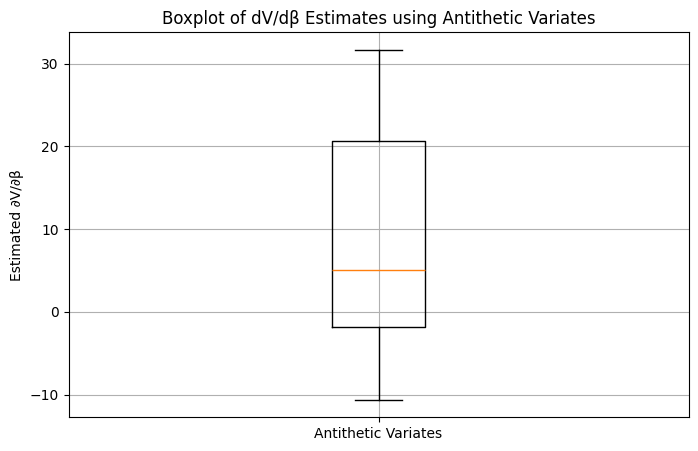

                Method  Mean dV/dβ  CI Lower   CI Upper
0  Antithetic Variates    8.249688 -0.513314  17.012689


In [19]:
# Antithetic Variates

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Parameter Settings
# -----------------------------
S0 = 65.15665    # Initial stock price
X  = 65          # Strike price
B  = 77.9        # Upper barrier
T  = 0.5         # Time to maturity
K  = 65          # Number of time steps
r  = 0.03       # Risk-free interest rate
alpha = 0.02
beta_base = 0.03 # Base β value
gamma = 1.07
sigma = 0.36
theta = 65.1404
dt = T / K      # Time step size

# Simulation parameters
N = 10000       # Total number of paths (must be even)
delta_beta = 0.001  # Perturbation of β
M = 10          # Number of repeated experiments

# -----------------------------
# 2. Antithetic Variates Monte Carlo Simulation Function
# -----------------------------
def av_mc_up_and_out(n_paths, beta_value, seed=42):
    """
    Simulate the price of an up-and-out call option using the Antithetic Variates method.
    Each pair of paths (using Z and -Z) is used to compute payoffs, and the average is taken.
    If any path hits the barrier, its payoff is set to 0.
    """
    # Ensure n_paths is even
    if n_paths % 2 != 0:
        n_paths += 1
    np.random.seed(seed)
    n_pairs = n_paths // 2
    pair_payoffs = np.zeros(n_pairs)
    
    for i in range(n_pairs):
        # Generate K standard normal random numbers for a pair of paths
        Z = np.random.randn(K)
        # Path 1: using Z; Path 2: using -Z
        S_t1 = S0
        S_t2 = S0
        barrier_hit1 = False
        barrier_hit2 = False
        
        for k in range(K):
            dW1 = np.sqrt(dt) * Z[k]
            dW2 = np.sqrt(dt) * (-Z[k])
            
            drift1 = (alpha * theta - beta_value * S_t1) * dt
            diffusion1 = sigma * (abs(S_t1)**gamma) * dW1
            drift2 = (alpha * theta - beta_value * S_t2) * dt
            diffusion2 = sigma * (abs(S_t2)**gamma) * dW2
            
            S_t1 = S_t1 + drift1 + diffusion1
            S_t2 = S_t2 + drift2 + diffusion2
            
            # Check if the barrier is hit
            if S_t1 > B:
                barrier_hit1 = True
            if S_t2 > B:
                barrier_hit2 = True
                
            # If both paths hit the barrier, exit the loop early
            if barrier_hit1 and barrier_hit2:
                break
        
        payoff1 = 0.0 if barrier_hit1 else max(S_t1 - X, 0)
        payoff2 = 0.0 if barrier_hit2 else max(S_t2 - X, 0)
        pair_payoffs[i] = 0.5 * (payoff1 + payoff2)
    
    option_price = np.exp(-r * T) * np.mean(pair_payoffs)
    return option_price

# -----------------------------
# 3. Estimating Finite Difference Derivative Using Antithetic Variates
# -----------------------------
def estimate_derivative_av(n_paths, delta_beta, M):
    """
    Repeat M experiments using the Antithetic Variates method to estimate the finite difference derivative:
    dV/dβ ≈ (V(S0, β=β_base+Δβ) - V(S0, β=β_base)) / Δβ
    """
    estimates = []
    for i in range(M):
        V1 = av_mc_up_and_out(n_paths, beta_base, seed=42+i)
        V2 = av_mc_up_and_out(n_paths, beta_base + delta_beta, seed=123+i)
        dV = (V2 - V1) / delta_beta
        estimates.append(dV)
    return np.array(estimates)

av_estimates = estimate_derivative_av(N, delta_beta, M)

# -----------------------------
# 4. Compute Mean and 95% Confidence Interval
# -----------------------------
def mean_confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)
    n = len(data)
    z = 1.96  # For large samples, use normal approximation
    half_width = z * (std_val / np.sqrt(n))
    return mean_val, mean_val - half_width, mean_val + half_width

av_mean, av_low, av_high = mean_confidence_interval(av_estimates)

print("=== Antithetic Variates Method for dV/dβ ===")
print(f"Mean dV/dβ = {av_mean:.5f}, 95% CI = ({av_low:.5f}, {av_high:.5f})")

# -----------------------------
# 5. Plot Boxplot of Results
# -----------------------------
plt.figure(figsize=(8,5))
plt.boxplot(av_estimates, tick_labels=["Antithetic Variates"])
plt.ylabel("Estimated ∂V/∂β")
plt.title("Boxplot of dV/dβ Estimates using Antithetic Variates")
plt.grid(True)
plt.show()

# -----------------------------
# 6. Store Results in a DataFrame and Print
# -----------------------------
df_av = pd.DataFrame({
    "Method": ["Antithetic Variates"],
    "Mean dV/dβ": [av_mean],
    "CI Lower": [av_low],
    "CI Upper": [av_high]
})
print(df_av)

=== Control Variate Method for dV/dβ ===
Mean dV/dβ = 8.31994, 95% CI = (-4.62425, 21.26412)


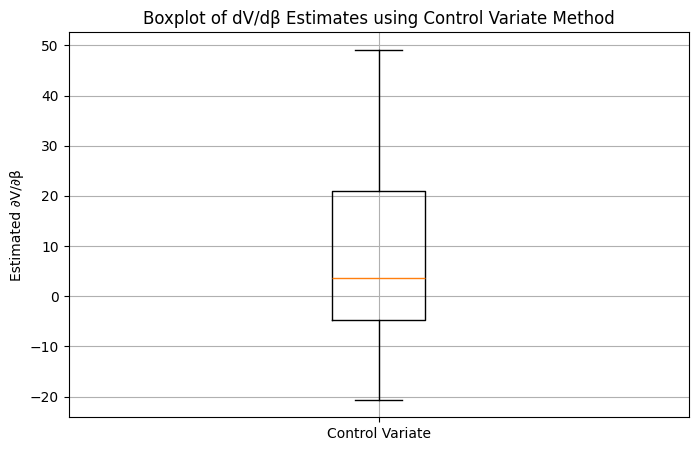

            Method  Mean dV/dβ  CI Lower   CI Upper
0  Control Variate    8.319935  -4.62425  21.264121


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------
# 1. Parameter Settings
# -----------------------------
S0 = 65.15665    # Initial stock price
X  = 65          # Strike price
B  = 77.9        # Upper barrier
T  = 0.5         # Time to maturity
K  = 65          # Number of time steps
r  = 0.03        # Risk-free interest rate
alpha = 0.02
beta_base = 0.03 # Base β value
gamma = 1.07
sigma = 0.36
theta = 65.1404
dt = T / K      # Time step size

# Simulation parameters
N = 10000       # Number of paths per experiment
delta_beta = 0.001  # Perturbation of β
M = 10          # Number of repeated experiments

# -----------------------------
# 2. Black-Scholes European Call Option Price (Control Variate Target Value)
# -----------------------------
def european_call_bs(S0, X, T, r, sigma):
    d1 = (np.log(S0/X) + (r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S0*norm.cdf(d1) - X*np.exp(-r*T)*norm.cdf(d2)
    return price

mu_euro = european_call_bs(S0, X, T, r, sigma)

# -----------------------------
# 3. Control Variate Monte Carlo Simulation Function
# -----------------------------
def cv_mc_up_and_out(n_paths, beta_value, seed=42):
    """
    Simulate the price of an up-and-out call option using the Control Variate method.
    For each path, both the barrier option payoff (X) and the European call payoff (Y) are calculated.
    The final estimate is adjusted using the optimal coefficient: X_adj = X + c*(mu - Y).
    The discounted average of all path payoffs is returned as the option price estimate.
    """
    np.random.seed(seed)
    X_payoffs = np.zeros(n_paths)  # Barrier option payoff
    Y_payoffs = np.zeros(n_paths)  # European call payoff (without barrier)
    
    for i in range(n_paths):
        S = S0
        barrier_hit = False
        
        # Generate a single path (K steps)
        Z = np.random.randn(K)
        for k in range(K):
            dW = np.sqrt(dt) * Z[k]
            drift = (alpha * theta - beta_value * S) * dt
            diffusion = sigma * (abs(S)**gamma) * dW
            S = S + drift + diffusion
            if S > B:
                barrier_hit = True
                # Even if knocked out, the European payoff still uses the final S value (barrier payoff is 0)
                # Can choose to exit early, use break below
                break
        
        if barrier_hit:
            X_payoffs[i] = 0.0
        else:
            X_payoffs[i] = max(S - X, 0)
        # European call payoff, independent of knockout
        Y_payoffs[i] = max(S - X, 0)
    
    # Control Variate: Estimate optimal coefficient c
    covXY = np.cov(X_payoffs, Y_payoffs, ddof=1)[0,1]
    varY = np.var(Y_payoffs, ddof=1)
    c_opt = covXY / varY if varY > 0 else 0.0
    
    # Adjusted payoff
    X_adj = X_payoffs + c_opt * (mu_euro - Y_payoffs)
    
    option_price = np.exp(-r * T) * np.mean(X_adj)
    return option_price

# -----------------------------
# 4. Estimating Finite Difference Derivative Using Control Variates
# -----------------------------
def estimate_derivative_cv(n_paths, delta_beta, M):
    """
    Repeat M experiments using the Control Variate method to estimate the finite difference derivative:
    dV/dβ ≈ [V(S0, β=β_base+Δβ) - V(S0, β=β_base)] / Δβ
    """
    estimates = []
    for i in range(M):
        V1 = cv_mc_up_and_out(n_paths, beta_base, seed=42+i)
        V2 = cv_mc_up_and_out(n_paths, beta_base + delta_beta, seed=123+i)
        dV = (V2 - V1) / delta_beta
        estimates.append(dV)
    return np.array(estimates)

cv_estimates = estimate_derivative_cv(N, delta_beta, M)

# -----------------------------
# 5. Compute Mean and 95% Confidence Interval
# -----------------------------
def mean_confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_val = np.std(data, ddof=1)
    n = len(data)
    z = 1.96  # Normal approximation for large samples
    half_width = z * (std_val / np.sqrt(n))
    return mean_val, mean_val - half_width, mean_val + half_width

cv_mean, cv_low, cv_high = mean_confidence_interval(cv_estimates)

print("=== Control Variate Method for dV/dβ ===")
print(f"Mean dV/dβ = {cv_mean:.5f}, 95% CI = ({cv_low:.5f}, {cv_high:.5f})")

# -----------------------------
# 6. Plot Boxplot of dV/dβ Estimates using Control Variates
# -----------------------------
plt.figure(figsize=(8,5))
plt.boxplot(cv_estimates, tick_labels=["Control Variate"])
plt.ylabel("Estimated ∂V/∂β")
plt.title("Boxplot of dV/dβ Estimates using Control Variate Method")
plt.grid(True)
plt.show()

# -----------------------------
# 7. Store Results in a DataFrame and Print
# -----------------------------
df_cv = pd.DataFrame({
    "Method": ["Control Variate"],
    "Mean dV/dβ": [cv_mean],
    "CI Lower": [cv_low],
    "CI Upper": [cv_high]
})
print(df_cv)
